In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


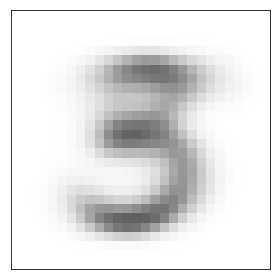

In [3]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [4]:
#Calculate mean training set conservation

entropy = (x_mean * -np.log(x_mean) + (1. - x_mean) * -np.log(1. - x_mean)) / np.log(2.0)
conservation = 1.0 - entropy

x_mean_conservation = np.mean(conservation)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.6384908141952594


In [5]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, :, :, 0]), 1e-8, 1. - 1e-8)

x_mean_broadcasted = np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))

kl_divs = (x_train_clipped * np.log(x_train_clipped / x_mean_broadcasted) + (1. - x_train_clipped) * np.log((1. - x_train_clipped) / (1. - x_mean_broadcasted))) / np.log(2.0)

x_mean_kl_divs = np.mean(kl_divs, axis=(1, 2))
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 0.36095131029187194


In [6]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/binary-stochastic-neurons-in-tensorflow.html
#See Github https://github.com/spitis/

def bernoulli_sample(x):
    g = tf.get_default_graph()
    with ops.name_scope("BernoulliSample") as name:
        with g.gradient_override_map({"Ceil": "Identity","Sub": "BernoulliSample_ST"}):
            return tf.ceil(x - tf.random_uniform(tf.shape(x)), name=name)

@ops.RegisterGradient("BernoulliSample_ST")
def bernoulliSample_ST(op, grad):
    return [grad, tf.zeros(tf.shape(op.inputs[1]))]


In [7]:
#Masking and Sampling helper functions

def sample_image_st(x) :
    p = tf.sigmoid(x)

    return bernoulli_sample(p)

#Generator helper functions
def initialize_templates(generator, background_matrices) :

    embedding_backgrounds = []

    for k in range(len(background_matrices)) :
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=1) :

    #Initialize Reshape layer
    reshape_layer = Reshape((n_rows, n_cols, 1))
    
    #Initialize background matrix
    background_dense = Embedding(n_classes, n_rows * n_cols, embeddings_initializer='zeros', name='background_dense')

    #Initialize Templating and Masking Lambda layer
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize Sigmoid layer
    image_layer = Lambda(lambda x: K.sigmoid(x), name='image')
    
    #Initialize Sampling layers
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_image_st, name='image_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, n_rows, n_cols, 1)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        background = reshape_layer(background_dense(class_input))
        
        #Add Template and Multiply Mask
        image_logits = background_layer([raw_logits, background])
        
        #Compute Image (Sigmoids from logits)
        image = image_layer(image_logits)
        
        #Tile each image to sample from and create sample axis
        image_logits_upsampled = upsampling_layer(image_logits)
        sampled_image = sampling_layer(image_logits_upsampled)
        sampled_image = permute_layer(sampled_image)
        
        return image_logits, image, sampled_image
    
    return _sampler_func


In [8]:
#Scrambler network definition

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0, batchnorm_trainmode=True) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor, training=batchnorm_trainmode) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=training)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=training)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_scrambler_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0, batchnorm_trainmode=True) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate, batchnorm_trainmode=batchnorm_trainmode))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='scrambler_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='softplus', kernel_initializer='glorot_normal', name='scrambler_final_conv')
    
    image_to_logits = Lambda(lambda x: 2. * x - 1., name='scrambler_image_to_logits')
    
    scale_logits = Lambda(lambda x: x[1] / K.maximum(x[0], K.epsilon()), name='scrambler_logit_scale')
    
    def _scrambler_func(image_input) :
        conv_0_out = conv_0(image_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        #Scale logits by importance scores
        scaled_logits = scale_logits([final_conv_out, image_to_logits(image_input)])
        
        return scaled_logits, final_conv_out

    return _scrambler_func


In [9]:
#Keras loss functions

def get_softmax_kl_divergence() :

    def _softmax_kl_divergence(y_true, y_pred) :

        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        return K.mean(K.sum(y_true * K.log(y_true / y_pred), axis=-1), axis=-1)
    
    return _softmax_kl_divergence

def get_margin_entropy_ame_masked(background, max_bits=1.0) :
    
    def _margin_entropy_ame_masked(image) :
        image_clipped = K.clip(image, K.epsilon(), 1. - K.epsilon())
        background_broadcasted = K.expand_dims(K.constant(background), axis=-1)
        
        conservation = (image[:, :, :, 0] * K.log(image_clipped[:, :, :, 0] / background_broadcasted) + (1. - image[:, :, :, 0]) * K.log((1. - image_clipped[:, :, :, 0]) / (1. - background_broadcasted))) / K.log(2.0)
        
        mean_conservation = K.mean(conservation, axis=(1, 2))

        margin_conservation = K.switch(mean_conservation > K.constant(max_bits, shape=(1,)), mean_conservation - K.constant(max_bits, shape=(1,)), K.zeros_like(mean_conservation))
    
        return margin_conservation
    
    return _margin_entropy_ame_masked

def get_target_entropy_sme_masked(background, target_bits=1.0) :
    
    def _target_entropy_sme_masked(image) :
        image_clipped = K.clip(image, K.epsilon(), 1. - K.epsilon())
        background_broadcasted = K.expand_dims(K.constant(background), axis=0)
        
        conservation = (image[:, :, :, 0] * K.log(image_clipped[:, :, :, 0] / background_broadcasted) + (1. - image[:, :, :, 0]) * K.log((1. - image_clipped[:, :, :, 0]) / (1. - background_broadcasted))) / K.log(2.0)
        
        mean_conservation = K.mean(conservation, axis=(1, 2))
        
        return (mean_conservation - target_bits)**2
    
    return _target_entropy_sme_masked

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [10]:
#Initialize Encoder and Decoder networks
batch_size = 32
n_rows = 28
n_cols = 28
n_samples = 32

#Resnet parameters
resnet_n_groups = 5
resnet_n_resblocks_per_group = 4
resnet_n_channels = 32
resnet_window_size = 3
resnet_dilation_rates = [1, 2, 4, 2, 1]
resnet_drop_rate = 0.0#0.25
resnet_batchnorm_trainmode = True

#Load scrambler
scrambler = load_scrambler_network(
    n_groups=resnet_n_groups,
    n_resblocks_per_group=resnet_n_resblocks_per_group,
    n_channels=resnet_n_channels, window_size=resnet_window_size,
    dilation_rates=resnet_dilation_rates,
    drop_rate=resnet_drop_rate,
    batchnorm_trainmode=resnet_batchnorm_trainmode
)

#Load sampler
sampler = build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=n_samples)


In [11]:
#Load Predictor
predictor_path = 'saved_models/mnist_binarized_cnn_10_digits.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [12]:
#Create inverted labels

digit_train = np.argmax(y_train, axis=-1)

y_train_inv = np.zeros(y_train.shape)
y_train_inv[digit_train == 3, 5] = 1.0
y_train_inv[digit_train == 5, 3] = 1.0

digit_test = np.argmax(y_test, axis=-1)

y_test_inv = np.zeros(y_test.shape)
y_test_inv[digit_test == 3, 5] = 1.0
y_test_inv[digit_test == 5, 3] = 1.0


In [13]:
#Build scrambler model
scrambler_class = Input(shape=(1,), name='scrambler_class')
scrambler_input = Input(shape=(n_rows, n_cols, 1), name='scrambler_input')

scrambled_logits, importance_scores = scrambler(scrambler_input)

image_logits, image, sampled_image = sampler(scrambler_class, scrambled_logits)

scrambler_model = Model([scrambler_input, scrambler_class], [image_logits, image, sampled_image, importance_scores])

#Initialize Templates and Masks
initialize_templates(scrambler_model, [x_mean_logits])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [14]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class = Input(shape=(1,), name='ae_scrambler_class')
ae_scrambler_input = Input(shape=(n_rows, n_cols, 1), name='ae_scrambler_input')
ae_label_input = Input(shape=(num_classes,), name='ae_label_input')

#Run encoder and decoder
_, scrambled_image, scrambled_sample = sampler(ae_scrambler_class, scrambler(ae_scrambler_input)[0])

#Define layer to deflate sample axis
deflate_scrambled_sample = Lambda(lambda x: K.reshape(x, (batch_size * n_samples, n_rows, n_cols, 1)), name='deflate_scrambled_sample')

#Deflate sample axis
scrambled_sample_deflated = deflate_scrambled_sample(scrambled_sample)

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled_deflated = ae_label_input#predictor([ae_scrambler_input])

#Make prediction on scrambled sequence samples
y_pred_scrambled_deflated = predictor([scrambled_sample_deflated])

#Define layer to inflate sample axis
inflate_non_scrambled_prediction = Lambda(lambda x: K.tile(K.expand_dims(x, axis=1), (1, n_samples, 1)), name='inflate_non_scrambled_prediction')
inflate_scrambled_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, num_classes)), name='inflate_scrambled_prediction')

#Inflate sample axis
y_pred_non_scrambled = inflate_non_scrambled_prediction(y_pred_non_scrambled_deflated)
y_pred_scrambled = inflate_scrambled_prediction(y_pred_scrambled_deflated)

#Cost function parameters
initial_target_bits = 0.3
target_bits = 0.30

#NLL cost
nll_loss_func = get_softmax_kl_divergence()

#Conservation cost
conservation_loss_func = get_target_entropy_sme_masked(background=x_mean, target_bits=initial_target_bits)

#Entropy cost
entropy_loss_func = get_target_entropy_sme_masked(background=x_mean, target_bits=target_bits)
#entropy_loss_func = get_margin_entropy_ame_masked(background=x_mean, max_bits=target_bits)

#Define annealing coefficient
anneal_coeff = K.variable(1.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1]), name='nll')([y_pred_non_scrambled, y_pred_scrambled])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x), name='conservation')(scrambled_image)

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x), name='entropy')(scrambled_image)

loss_model = Model(
    [ae_scrambler_class, ae_scrambler_input, ae_label_input],
    [nll_loss, conservation_loss, entropy_loss]
)

#Initialize Templates and Masks
initialize_templates(loss_model, [x_mean_logits])

loss_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=1200.0)
    }
)


In [15]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
scrambler_conv_0 (Conv2D)       (None, 28, 28, 32)   64          scrambler_input[0][0]            
__________________________________________________________________________________________________
scrambler_resblock_0_0_batch_no (None, 28, 28, 32)   128         scrambler_conv_0[0][0]           
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 28, 28, 32)   0           scrambler_resblock_0_0_batch_norm
__________________________________________________________________________________________________
scrambler_

In [16]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input (InputLayer) (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
scrambler_conv_0 (Conv2D)       (None, 28, 28, 32)   64          ae_scrambler_input[0][0]         
__________________________________________________________________________________________________
scrambler_resblock_0_0_batch_no (None, 28, 28, 32)   128         scrambler_conv_0[1][0]           
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 28, 28, 32)   0           scrambler_resblock_0_0_batch_norm
__________________________________________________________________________________________________
scrambler_

In [17]:
#Training configuration

#Define number of training epochs
n_epochs = 50

#Define experiment suffix (optional)
experiment_suffix = "_kl_divergence_even_higher_entropy_penalty"

#Define anneal function
def _anneal_func(val, epoch, n_epochs=n_epochs) :
    if epoch in [0] :
        return 1.0
    
    return 0.0

architecture_str = "resnet_" + str(resnet_n_groups) + "_" + str(resnet_n_resblocks_per_group) + "_" + str(resnet_n_channels) + "_" + str(resnet_window_size) + "_" + str(resnet_drop_rate).replace(".", "")

model_name = "autoscrambler_dataset_" + dataset_name + "_inverted_scores_n_samples_" + str(n_samples) + "_" + architecture_str + "_n_epochs_" + str(n_epochs) + "_target_bits_" + str(target_bits).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_mnist_3_vs_5_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_50_target_bits_03_kl_divergence_even_higher_entropy_penalty


In [18]:
#Execute training procedure

callbacks =[
    #ModelCheckpoint("model_checkpoints/" + model_name + "_epoch_{epoch:02d}.hdf5", monitor='val_loss', mode='min', period=10, save_weights_only=True),
    EpochVariableCallback(anneal_coeff, _anneal_func)
]

s_train = np.zeros((x_train.shape[0], 1))
s_test = np.zeros((x_test.shape[0], 1))

# train the autoencoder
train_history = loss_model.fit(
    [s_train, x_train, y_train_inv],
    [s_train, s_train, s_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [s_test, x_test, y_test_inv],
        [s_test, s_test, s_test]
    ),
    callbacks=callbacks
)


Train on 11552 samples, validate on 1888 samples
Epoch 1/50
11552/11552 [==============================] - 61s 5ms/step - loss: 2.0277 - nll_loss: 1.9580 - conservation_loss: 0.0697 - entropy_loss: 0.0000e+00 - val_loss: 0.9930 - val_nll_loss: 0.9292 - val_conservation_loss: 0.0639 - val_entropy_loss: 0.0000e+00
Epoch 2/50
11552/11552 [==============================] - 43s 4ms/step - loss: 7.8615 - nll_loss: 4.4314 - conservation_loss: 0.0000e+00 - entropy_loss: 3.4300 - val_loss: 5.1458 - val_nll_loss: 2.4343 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 2.7115
Epoch 3/50
11552/11552 [==============================] - 43s 4ms/step - loss: 4.9046 - nll_loss: 2.7195 - conservation_loss: 0.0000e+00 - entropy_loss: 2.1852 - val_loss: 4.5106 - val_nll_loss: 2.4696 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 2.0410
Epoch 4/50
11552/11552 [==============================] - 43s 4ms/step - loss: 4.3736 - nll_loss: 2.4443 - conservation_loss: 0.0000e+00 - entropy_loss: 1.9

Epoch 32/50
11552/11552 [==============================] - 44s 4ms/step - loss: 2.8425 - nll_loss: 1.5327 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3098 - val_loss: 2.6958 - val_nll_loss: 1.2256 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4703
Epoch 33/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8109 - nll_loss: 1.5053 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3056 - val_loss: 2.7655 - val_nll_loss: 1.2753 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4902
Epoch 34/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8313 - nll_loss: 1.4904 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3408 - val_loss: 2.7241 - val_nll_loss: 1.2048 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5194
Epoch 35/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8090 - nll_loss: 1.4760 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3330 - val_loss: 2.7488 - val_nll_loss: 1.1963

In [18]:

loss_str = """
Train on 11552 samples, validate on 1888 samples
Epoch 1/50
11552/11552 [==============================] - 61s 5ms/step - loss: 2.0277 - nll_loss: 1.9580 - conservation_loss: 0.0697 - entropy_loss: 0.0000e+00 - val_loss: 0.9930 - val_nll_loss: 0.9292 - val_conservation_loss: 0.0639 - val_entropy_loss: 0.0000e+00
Epoch 2/50
11552/11552 [==============================] - 43s 4ms/step - loss: 7.8615 - nll_loss: 4.4314 - conservation_loss: 0.0000e+00 - entropy_loss: 3.4300 - val_loss: 5.1458 - val_nll_loss: 2.4343 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 2.7115
Epoch 3/50
11552/11552 [==============================] - 43s 4ms/step - loss: 4.9046 - nll_loss: 2.7195 - conservation_loss: 0.0000e+00 - entropy_loss: 2.1852 - val_loss: 4.5106 - val_nll_loss: 2.4696 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 2.0410
Epoch 4/50
11552/11552 [==============================] - 43s 4ms/step - loss: 4.3736 - nll_loss: 2.4443 - conservation_loss: 0.0000e+00 - entropy_loss: 1.9293 - val_loss: 4.1412 - val_nll_loss: 2.1938 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.9474
Epoch 5/50
11552/11552 [==============================] - 44s 4ms/step - loss: 4.0460 - nll_loss: 2.2694 - conservation_loss: 0.0000e+00 - entropy_loss: 1.7765 - val_loss: 3.8485 - val_nll_loss: 1.8561 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.9925
Epoch 6/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.8825 - nll_loss: 2.1476 - conservation_loss: 0.0000e+00 - entropy_loss: 1.7349 - val_loss: 3.7690 - val_nll_loss: 1.8647 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.9043
Epoch 7/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.7439 - nll_loss: 2.0831 - conservation_loss: 0.0000e+00 - entropy_loss: 1.6608 - val_loss: 3.6584 - val_nll_loss: 1.9648 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6936
Epoch 8/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.6102 - nll_loss: 2.0009 - conservation_loss: 0.0000e+00 - entropy_loss: 1.6093 - val_loss: 3.4457 - val_nll_loss: 1.5612 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.8845
Epoch 9/50
11552/11552 [==============================] - 44s 4ms/step - loss: 3.5175 - nll_loss: 1.9526 - conservation_loss: 0.0000e+00 - entropy_loss: 1.5650 - val_loss: 3.4685 - val_nll_loss: 1.3986 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 2.0698
Epoch 10/50
11552/11552 [==============================] - 44s 4ms/step - loss: 3.4461 - nll_loss: 1.9191 - conservation_loss: 0.0000e+00 - entropy_loss: 1.5270 - val_loss: 3.2738 - val_nll_loss: 1.7425 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5313
Epoch 11/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.3707 - nll_loss: 1.8780 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4927 - val_loss: 3.2771 - val_nll_loss: 1.7458 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5313
Epoch 12/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.3318 - nll_loss: 1.8568 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4750 - val_loss: 3.2321 - val_nll_loss: 1.6875 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5446
Epoch 13/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.2779 - nll_loss: 1.8026 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4754 - val_loss: 3.3308 - val_nll_loss: 1.4782 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.8526
Epoch 14/50
11552/11552 [==============================] - 44s 4ms/step - loss: 3.2267 - nll_loss: 1.7812 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4455 - val_loss: 3.0587 - val_nll_loss: 1.3958 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6629
Epoch 15/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.1848 - nll_loss: 1.7413 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4435 - val_loss: 3.0202 - val_nll_loss: 1.6731 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.3471
Epoch 16/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.1194 - nll_loss: 1.7270 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3924 - val_loss: 2.9563 - val_nll_loss: 1.2657 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6906
Epoch 17/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.1141 - nll_loss: 1.7062 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4079 - val_loss: 3.0093 - val_nll_loss: 1.3598 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6496
Epoch 18/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.0786 - nll_loss: 1.6737 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4049 - val_loss: 2.9719 - val_nll_loss: 1.1811 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.7908
Epoch 19/50
11552/11552 [==============================] - 44s 4ms/step - loss: 3.0784 - nll_loss: 1.6639 - conservation_loss: 0.0000e+00 - entropy_loss: 1.4145 - val_loss: 2.9807 - val_nll_loss: 1.4410 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5397
Epoch 20/50
11552/11552 [==============================] - 44s 4ms/step - loss: 3.0554 - nll_loss: 1.6657 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3897 - val_loss: 2.8779 - val_nll_loss: 1.4243 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4537
Epoch 21/50
11552/11552 [==============================] - 44s 4ms/step - loss: 3.0035 - nll_loss: 1.6337 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3699 - val_loss: 2.9674 - val_nll_loss: 1.5103 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4572
Epoch 22/50
11552/11552 [==============================] - 43s 4ms/step - loss: 3.0013 - nll_loss: 1.6236 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3778 - val_loss: 2.8519 - val_nll_loss: 1.3486 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5033
Epoch 23/50
11552/11552 [==============================] - 44s 4ms/step - loss: 2.9693 - nll_loss: 1.6191 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3502 - val_loss: 2.9304 - val_nll_loss: 1.5904 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.3400
Epoch 24/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.9558 - nll_loss: 1.5868 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3690 - val_loss: 2.8281 - val_nll_loss: 1.3389 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4892
Epoch 25/50
11552/11552 [==============================] - 44s 4ms/step - loss: 2.9316 - nll_loss: 1.5635 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3681 - val_loss: 2.8462 - val_nll_loss: 1.2189 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6272
Epoch 26/50
11552/11552 [==============================] - 44s 4ms/step - loss: 2.9072 - nll_loss: 1.5586 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3486 - val_loss: 2.7954 - val_nll_loss: 1.2633 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5320
Epoch 27/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.9171 - nll_loss: 1.5740 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3432 - val_loss: 2.8555 - val_nll_loss: 1.5156 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.3400
Epoch 28/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.9214 - nll_loss: 1.5450 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3763 - val_loss: 2.7672 - val_nll_loss: 1.2261 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5411
Epoch 29/50
11552/11552 [==============================] - 44s 4ms/step - loss: 2.8719 - nll_loss: 1.5422 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3297 - val_loss: 2.7691 - val_nll_loss: 1.0665 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.7026
Epoch 30/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8630 - nll_loss: 1.5076 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3554 - val_loss: 2.8280 - val_nll_loss: 1.4925 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.3354
Epoch 31/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8652 - nll_loss: 1.5292 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3360 - val_loss: 2.7544 - val_nll_loss: 1.3977 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.3567
Epoch 32/50
11552/11552 [==============================] - 44s 4ms/step - loss: 2.8425 - nll_loss: 1.5327 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3098 - val_loss: 2.6958 - val_nll_loss: 1.2256 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4703
Epoch 33/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8109 - nll_loss: 1.5053 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3056 - val_loss: 2.7655 - val_nll_loss: 1.2753 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4902
Epoch 34/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8313 - nll_loss: 1.4904 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3408 - val_loss: 2.7241 - val_nll_loss: 1.2048 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5194
Epoch 35/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.8090 - nll_loss: 1.4760 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3330 - val_loss: 2.7488 - val_nll_loss: 1.1963 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5525
Epoch 36/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.7828 - nll_loss: 1.4832 - conservation_loss: 0.0000e+00 - entropy_loss: 1.2996 - val_loss: 2.6892 - val_nll_loss: 1.0967 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5925
Epoch 37/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.7937 - nll_loss: 1.4631 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3306 - val_loss: 2.7003 - val_nll_loss: 1.1608 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5396
Epoch 38/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.7992 - nll_loss: 1.4542 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3449 - val_loss: 2.6906 - val_nll_loss: 1.1006 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5900
Epoch 39/50
11552/11552 [==============================] - 43s 4ms/step - loss: 2.7942 - nll_loss: 1.4513 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3429 - val_loss: 2.6454 - val_nll_loss: 1.1019 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5435
Epoch 40/50
11552/11552 [==============================] - 36s 3ms/step - loss: 2.7778 - nll_loss: 1.4532 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3247 - val_loss: 2.6979 - val_nll_loss: 1.2850 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.4130
Epoch 41/50
11552/11552 [==============================] - 32s 3ms/step - loss: 2.7778 - nll_loss: 1.4627 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3151 - val_loss: 2.6278 - val_nll_loss: 1.1202 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5075
Epoch 42/50
11552/11552 [==============================] - 31s 3ms/step - loss: 2.7622 - nll_loss: 1.4506 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3116 - val_loss: 2.6424 - val_nll_loss: 1.0157 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6266
Epoch 43/50
11552/11552 [==============================] - 31s 3ms/step - loss: 2.7761 - nll_loss: 1.4563 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3198 - val_loss: 2.7898 - val_nll_loss: 1.1236 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6661
Epoch 44/50
11552/11552 [==============================] - 31s 3ms/step - loss: 2.7574 - nll_loss: 1.4508 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3065 - val_loss: 2.6816 - val_nll_loss: 1.0889 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5927
Epoch 45/50
11552/11552 [==============================] - 31s 3ms/step - loss: 2.7677 - nll_loss: 1.4423 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3253 - val_loss: 2.6780 - val_nll_loss: 1.1355 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5424
Epoch 46/50
11552/11552 [==============================] - 31s 3ms/step - loss: 2.7484 - nll_loss: 1.4602 - conservation_loss: 0.0000e+00 - entropy_loss: 1.2882 - val_loss: 2.6206 - val_nll_loss: 1.3107 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.3099
Epoch 47/50
11552/11552 [==============================] - 31s 3ms/step - loss: 2.7249 - nll_loss: 1.4479 - conservation_loss: 0.0000e+00 - entropy_loss: 1.2770 - val_loss: 2.6561 - val_nll_loss: 0.9597 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.6965
Epoch 48/50
11552/11552 [==============================] - 24s 2ms/step - loss: 2.7195 - nll_loss: 1.4254 - conservation_loss: 0.0000e+00 - entropy_loss: 1.2940 - val_loss: 2.7001 - val_nll_loss: 1.1671 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5330
Epoch 49/50
11552/11552 [==============================] - 23s 2ms/step - loss: 2.7206 - nll_loss: 1.4194 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3012 - val_loss: 2.5701 - val_nll_loss: 1.2736 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.2965
Epoch 50/50
11552/11552 [==============================] - 21s 2ms/step - loss: 2.7114 - nll_loss: 1.3783 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3331 - val_loss: 2.6503 - val_nll_loss: 1.1186 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5316
"""


In [19]:

loss_keys = [
    "nll_loss",
    "entropy_loss",
    "conservation_loss"
]

class DummyHistory() :
    
    def __init__(self) :
        self.history = {}

train_history = DummyHistory()

loss_str_modified = loss_str.replace("\n", " - \n")

for loss_key in loss_keys :
    loss_vec = [float(loss_part.split(" - ")[0]) for loss_part in loss_str_modified.split(" " + loss_key + ": ")[1:]]
    val_loss_vec = [float(loss_part.split(" - ")[0]) for loss_part in loss_str_modified.split(" val_" + loss_key + ": ")[1:]]
    
    train_history.history[loss_key] = loss_vec
    train_history.history["val_" + loss_key] = val_loss_vec


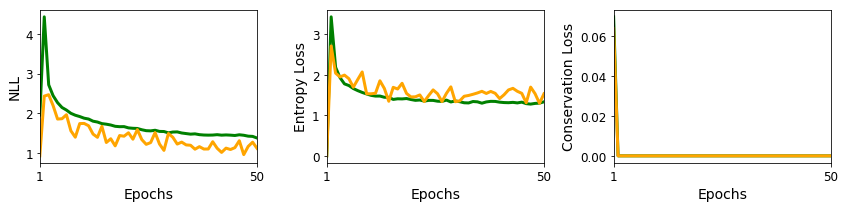

In [20]:

save_figs = True

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

n_epochs_actual = len(train_history.history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['conservation_loss'], linewidth=3, color='green')
ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_conservation_loss'], linewidth=3, color='orange')

plt.sca(ax3)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Conservation Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + "_loss.png", transparent=True, dpi=300)
    plt.savefig(model_name + "_loss.eps")

plt.show()


In [20]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler_model.save(model_path)
print('Saved scrambler model at %s ' % (model_path))


Saved scrambler model at saved_models/autoscrambler_dataset_mnist_3_vs_5_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_50_target_bits_03_kl_divergence_even_higher_entropy_penalty.h5 


In [21]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model = load_model(model_path, custom_objects={
    'bernoulli_sample' : bernoulli_sample,
    'tf' : tf
})

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_mnist_3_vs_5_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_50_target_bits_03_kl_divergence_even_higher_entropy_penalty.h5 


Test image 0:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.01, 0.01, 0.0, 0.66, 0.0, 0.08, 0.05, 0.0, 0.09, 0.07]


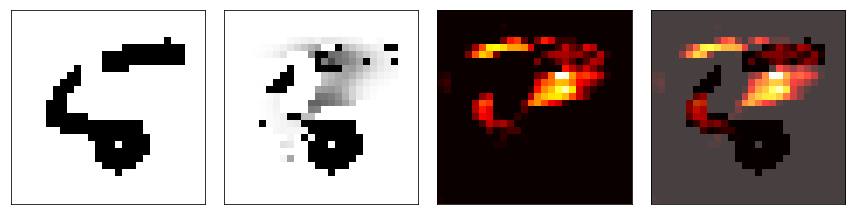

Test image 1:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


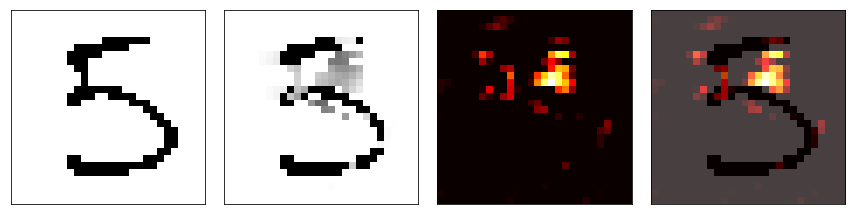

Test image 2:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0]


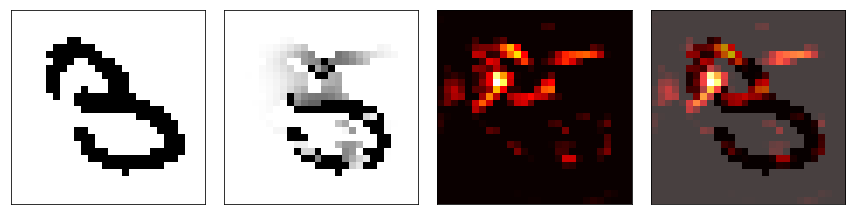

Test image 3:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.64, 0.08, 0.84, 0.0, 0.0, 0.82, 0.85, 1.0, 0.07, 0.01]


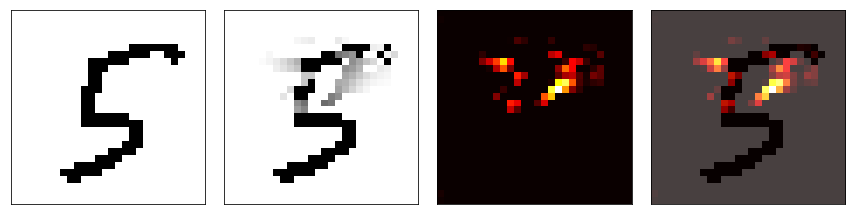

Test image 4:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.47, 0.0, 0.47, 0.97, 0.99, 0.24, 0.0, 0.87, 0.0, 0.0]


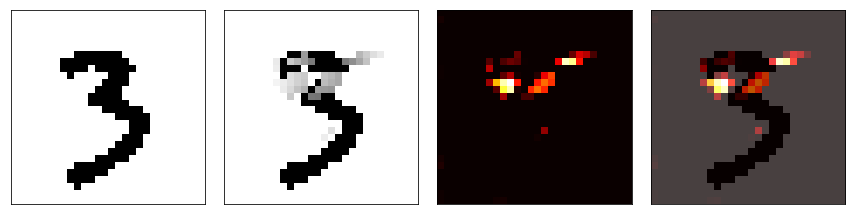

Test image 5:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.2, 0.83, 0.0, 0.01, 0.0, 0.0, 0.73, 0.95, 0.01, 0.5]


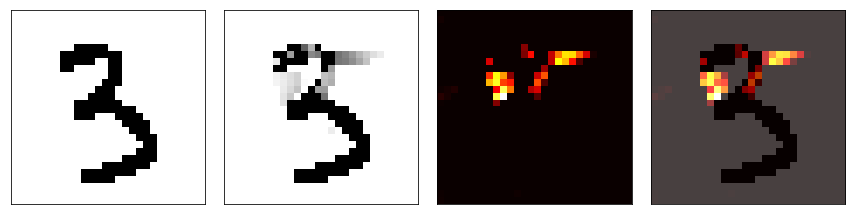

Test image 6:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.76, 0.0, 0.0, 0.02, 0.02, 0.06, 0.99, 0.25, 0.64, 0.03]


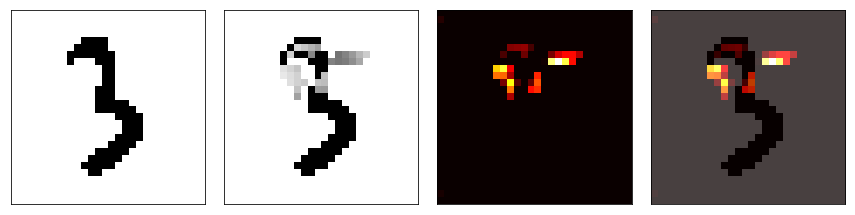

Test image 7:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0, 0.01, 0.29, 0.98, 1.0, 0.0, 1.0, 1.0, 0.78, 1.0]


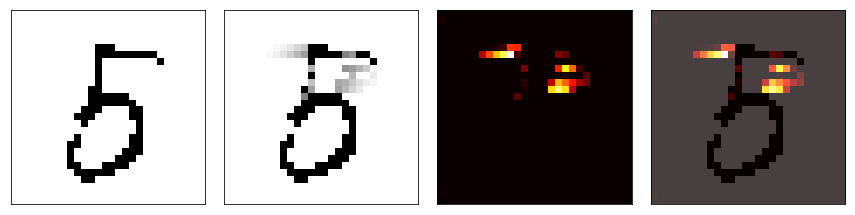

Test image 8:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0]


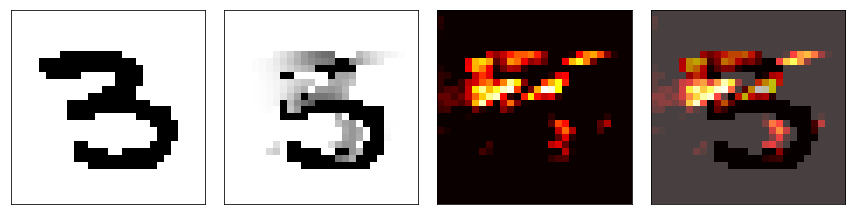

Test image 9:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.99, 0.0, 0.0, 0.74, 0.0, 0.14, 0.0, 0.11, 0.09]


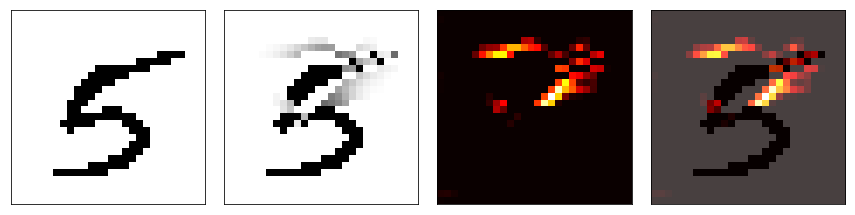

Test image 10:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


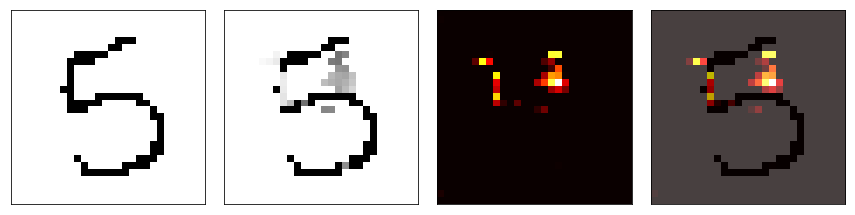

Test image 11:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.12, 0.17, 0.04, 0.59, 0.34, 0.05, 0.0, 0.0, 0.03, 0.04]


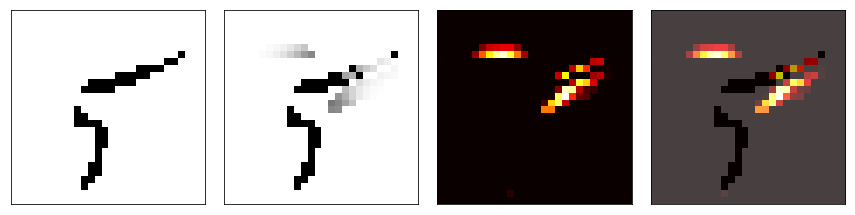

Test image 12:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.01, 0.0, 0.67]


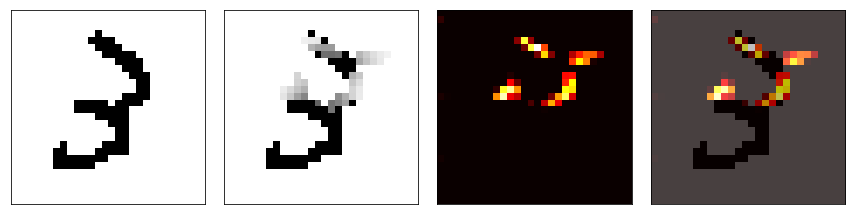

Test image 13:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.22, 0.0, 0.0, 1.0, 0.92, 0.0, 0.0, 0.03, 0.02, 0.05]


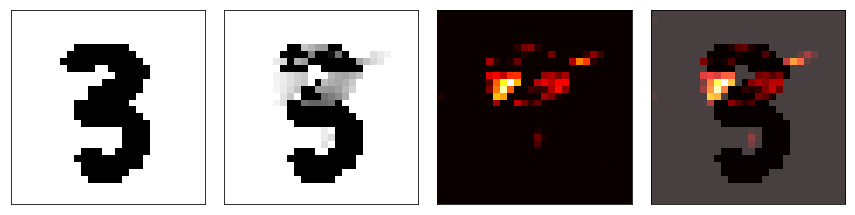

Test image 14:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.53, 0.0, 0.0, 0.11, 0.34, 0.72, 0.16, 0.94]


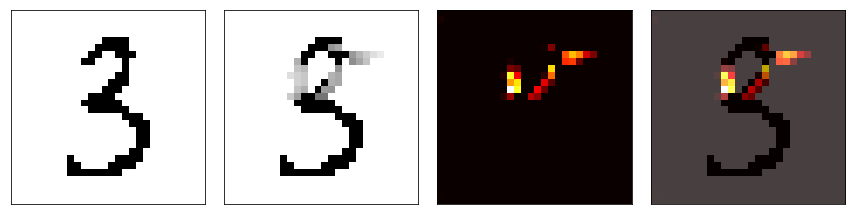

Test image 15:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.07, 0.0, 0.95, 0.0, 0.93, 0.0, 0.79, 0.29, 0.0, 0.04]


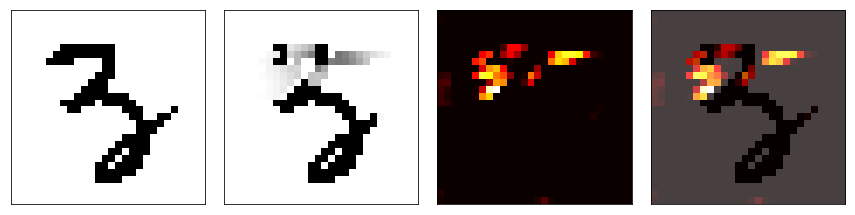

Test image 16:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.06, 0.0, 0.15, 1.0, 0.0, 0.05, 0.01, 0.66, 0.89, 0.0]


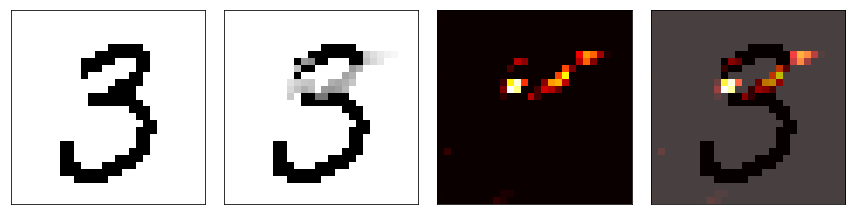

Test image 17:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.0, 0.36, 0.0, 0.0]


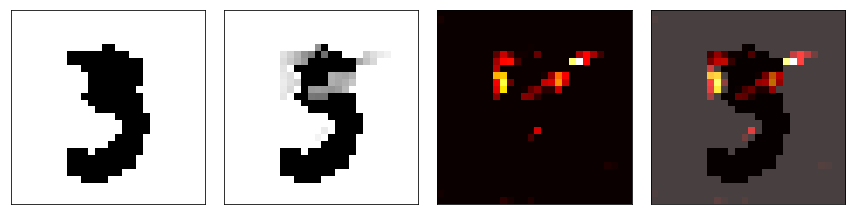

Test image 18:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0]


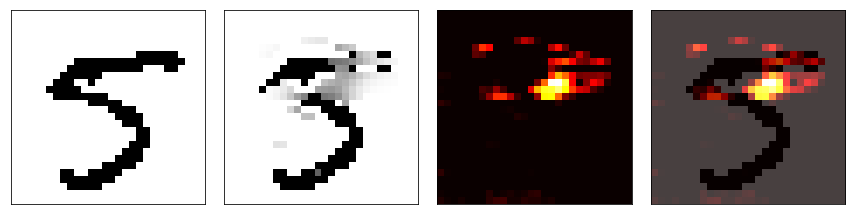

Test image 19:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.99, 0.0, 0.38, 0.0, 1.0]


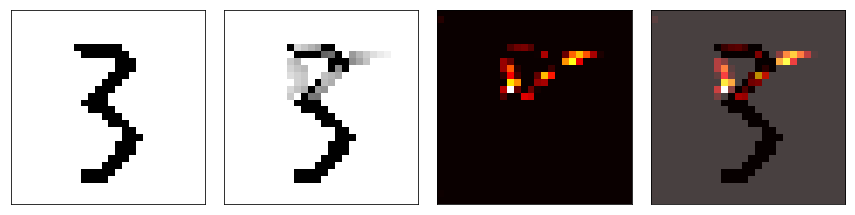

In [22]:
#Visualize a few reconstructed images

from numpy.ma import masked_array

digit_test = np.argmax(y_test, axis=1)

s_test = np.zeros((x_test.shape[0], 1))

_, image_test, sample_test, importance_scores_test = scrambler_model.predict_on_batch(x=[x_test[:32], s_test[:32]])

save_images = [3, 4]

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[plot_i], axis=0)], batch_size=1)[0, digit_test[plot_i]]
    y_test_hat = predictor.predict(x=[sample_test[plot_i]], batch_size=32)[:10, digit_test[plot_i]].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    if save_images is not None and plot_i in save_images :
        plt.savefig(model_name + "_test_example_" + str(plot_i) + ".png", transparent=True, dpi=300)
        plt.savefig(model_name + "_test_example_" + str(plot_i) + ".eps")
    
    plt.show()


In [23]:
#Visualize a few reconstructed images

digit_test = np.argmax(y_test, axis=1)

s_test = np.zeros((x_test.shape[0], 1))

_, image_test, sample_test, importance_scores_test = scrambler_model.predict(x=[x_test, s_test], batch_size=32, verbose=True)


1888/1888 [==============================] - 1s 330us/step


In [25]:
#Save predicted importance scores

np.save(model_name + "_importance_scores_test", importance_scores_test)
